# Распознавание животных на изображениях

Базовый ноутбук для домашнего задания по распознаванию животных. 

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

<a target="_blank" href="https://colab.research.google.com/github/sozykin/dlpython_course/blob/master/cnn/tensorflow/animals.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow import data
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
%matplotlib inline

In [21]:
# Порядок классов животных
class_names=['cat',
             'elephant',
             'butterfly', 
             'sheep',
             'spider',
             'horse',
             'dog',
             'cow',
             'chicken',
             'squirrel']

## Подготовка данных

Загружаем данные для обучения

In [22]:
!curl -s -L -o train.zip "https://www.dropbox.com/scl/fi/t91ykrvtwupimxlf5xv9f/train.zip?rlkey=k0of0w0x6gsm0l33eylflub9c&dl=1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    17  100    17    0     0     25      0 --:--:-- --:--:-- --:--:--    25

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   475    0   475    0     0    263      0 --:--:--  0:00:01 --:--:--   428
100   475    0   475    0     0    263      0 --:--:--  0:00:01 --:--:--   428

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0  450M    0 49152    0     0  11087      0 11:49:21  0:00:04 11:49:17 30472
  0  450M    0  112k    0     0  22957      0  5:42:34  0:00:04  5:42:30 52705
  0  450M    0  160k    0     0  28132      0  4:39:33  0:00:05  4:39:28 54540
  0  450M    0  256k    0     0  37142      0  3:31:44  0:00:07  3:31:37 61855
  0  450M    0  320k    0     0  42506      0  3:

Распаковываем архив с обучающим набором данных

In [3]:
data_path = 'data'

In [4]:
path = Path(data_path)

if not path.exists():
    path.mkdir(parents=True, exist_ok=True)

In [24]:
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)

**Создаем DataSet'ы**

In [25]:
batch_size = 64
image_size = (100, 100)

Набор данных для обучения

In [26]:
train_dataset = image_dataset_from_directory(
    "data/train", 
    image_size=image_size, 
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    class_names=class_names,    
    seed=42
)

Found 21949 files belonging to 10 classes.
Using 17560 files for training.


Проверочный набор данных

In [27]:
val_dataset = image_dataset_from_directory(
    "data/train", 
    image_size=image_size, 
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    class_names=class_names,     
    seed=42
)

Found 21949 files belonging to 10 classes.
Using 4389 files for validation.


**Просмотр примеров данных**

In [28]:
train_dataset.class_names

['cat',
 'elephant',
 'butterfly',
 'sheep',
 'spider',
 'horse',
 'dog',
 'cow',
 'chicken',
 'squirrel']

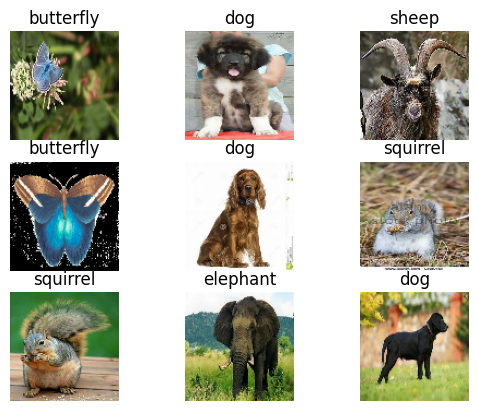

In [29]:
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Настраиваем производительность работы DataSet'ов**

In [30]:
AUTOTUNE = data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [31]:
# Создаем последовательную модель
model = Sequential(
    [
        # Предварительная обработка: нормализация
        Rescaling(1./255),
        # Первый сверточный слой
        Conv2D(32, (3, 3), activation='relu'),
        # Первый слой подвыборки
        MaxPooling2D(pool_size=(2, 2)),
        # Слой регуляризации Dropout
        Dropout(0.25),

        # Второй сверточный слой
        Conv2D(64, (3, 3), activation='relu'),
        # Второй слой подвыборки
        MaxPooling2D(pool_size=(2, 2)),
        # Слой регуляризации Dropout
        Dropout(0.25),

        # Слой преобразования данных из 2D представления в плоское
        Flatten(),
        # Полносвязный слой для классификации
        Dense(512, activation='relu'),
        # Слой регуляризации Dropout
        Dropout(0.5),
        # Выходной полносвязный слой
        Dense(10, activation='softmax')
    ]
)

**Компилируем модель**

In [32]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [33]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 74s 204ms/step - accuracy: 0.3440 - loss: 1.9000 - val_accuracy: 0.4600 - val_loss: 1.5889
Epoch 2/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 53s 192ms/step - accuracy: 0.5039 - loss: 1.4676 - val_accuracy: 0.5432 - val_loss: 1.3715
Epoch 3/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 54s 198ms/step - accuracy: 0.5751 - loss: 1.2607 - val_accuracy: 0.5981 - val_loss: 1.2183
Epoch 4/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 54s 197ms/step - accuracy: 0.6382 - loss: 1.0841 - val_accuracy: 0.6266 - val_loss: 1.1234
Epoch 5/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 55s 199ms/step - accuracy: 0.6850 - loss: 0.9353 - val_accuracy: 0.6398 - val_loss: 1.1038
Epoch 6/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 51s 185ms/step - accuracy: 0.7393 - loss: 0.7826 - val_accuracy: 0.6423 - val_loss: 1.1119
Epoch 7/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 53s 193ms/step - accuracy: 0.7735 - loss: 0.6616 - val_accuracy: 0.6550 - val_loss: 1.0714
Epoch 8/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 51s 184ms/step - accuracy: 0.8167 - loss: 0

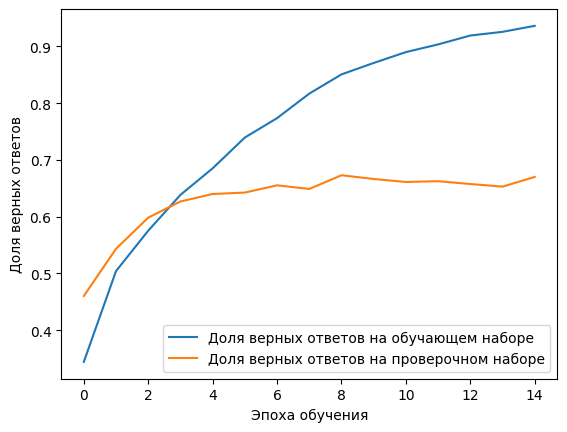

In [34]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

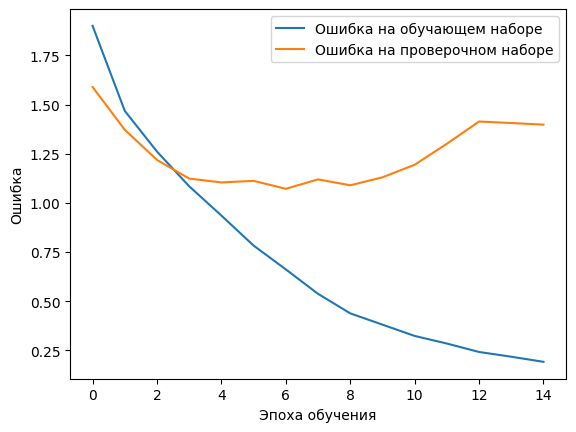

In [35]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [36]:
model.save("animals.keras")

## Применяем сеть для распознавания объектов на изображениях

**Смотрим загруженную картинку**

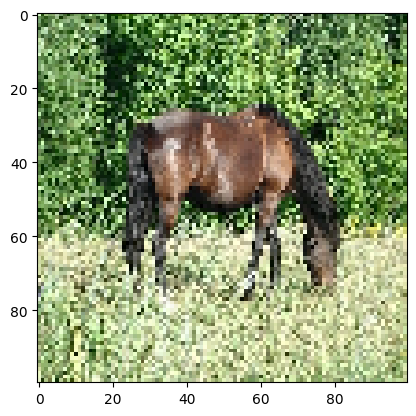

In [37]:
img_path = '../horse.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

**Преобразуем картинку в массив для распознавания**

In [38]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

**Запускаем распознавание**

In [39]:
prediction = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [40]:
prediction

array([[3.1637912e-05, 2.3789449e-01, 2.8127322e-05, 3.1085347e-04,
        4.7106110e-05, 5.7951677e-01, 7.9406038e-02, 2.7177751e-03,
        4.3710191e-02, 5.6337021e-02]], dtype=float32)

In [41]:
prediction = np.argmax(prediction)


In [42]:
prediction

np.int64(5)

In [43]:
print(class_names[prediction])

horse


**Обязательно попробуйте распознать свои изображения!**

## Распознаем изображения их тестового набора данных

Загружаем данные для распознавания

In [44]:
!curl -s -L -o test.zip "https://www.dropbox.com/scl/fi/ho3jmmnbpddu183p4nug0/test.zip?rlkey=595fmuikf204gq8gzfjvyr4b5&dl=1"

Распаковываем архив

In [45]:
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)

Тестовый набор данных

In [46]:
test_dataset = image_dataset_from_directory(
    "data/test", 
    image_size=image_size, 
    batch_size=batch_size,
    labels=None,
    shuffle=False,
)

Found 2440 files.


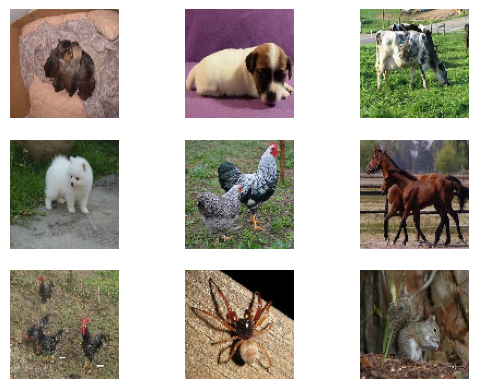

In [47]:
for images in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [48]:
predictions = model.predict(test_dataset)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


In [49]:
predictions[:10]

array([[7.91072263e-04, 2.48121053e-01, 1.24759303e-04, 7.24965648e-04,
        1.65404063e-02, 2.46238569e-03, 6.43611848e-01, 3.44054401e-03,
        8.24012458e-02, 1.78173312e-03],
       [1.42149229e-05, 2.85070182e-05, 7.70949737e-06, 1.49782254e-05,
        2.59551302e-06, 3.36701679e-03, 9.74711835e-01, 4.50650987e-06,
        2.18455568e-02, 3.11276244e-06],
       [2.12302871e-06, 7.93407082e-07, 2.69512079e-09, 3.17951515e-02,
        3.91847088e-08, 4.21029516e-03, 1.97224203e-03, 9.60966349e-01,
        1.05296134e-03, 2.86066424e-08],
       [3.64396910e-05, 3.27593807e-05, 9.40987377e-08, 4.72482992e-04,
        1.05484980e-06, 2.52631115e-04, 9.99038696e-01, 6.09794479e-05,
        1.03310835e-04, 1.61064736e-06],
       [1.54198446e-07, 1.26518742e-08, 3.63405616e-06, 3.22589731e-05,
        1.10183885e-06, 2.61798387e-08, 2.47473793e-07, 2.30386785e-08,
        9.99960542e-01, 2.02485330e-06],
       [4.24459625e-18, 4.68154404e-09, 2.24035613e-19, 8.73955075e-10,
   

In [50]:
predictions = np.argmax(predictions, axis=1)

In [51]:
predictions[:10]

array([6, 6, 7, 6, 8, 5, 9, 4, 9, 6])

## Готовим файл с решением

In [52]:
submission = pd.DataFrame({
    'filepath': test_dataset.file_paths,
    'label': predictions
})

In [53]:
submission

,filepath,label
0,data/test\OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,6
1,data/test\OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,6
2,data/test\OIP--XIpeXErEIOwRtUWh75BPAHaFj.jpeg,7
3,data/test\OIP--XK9fGfui8Yd_sI6-rKx-AHaFj.jpeg,6
4,data/test\OIP--XN4Ve2B0ry96ORfDjk_bgHaGl.jpeg,8
...,...,...
2435,data/test\q-aila-162475-unsplash.jpg,4
2436,data/test\sam-burriss-378658-unsplash.jpg,4
2437,data/test\sarah-dorweiler-128578-unsplash.jpg,6
2438,data/test\xenia-bogarova-422041-unsplash.jpg,9


In [54]:
submission['id'] = submission['filepath'].apply(lambda x: Path(x).name)

In [55]:
submission

,filepath,label,id
0,data/test\OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,6,OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg
1,data/test\OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,6,OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg
2,data/test\OIP--XIpeXErEIOwRtUWh75BPAHaFj.jpeg,7,OIP--XIpeXErEIOwRtUWh75BPAHaFj.jpeg
3,data/test\OIP--XK9fGfui8Yd_sI6-rKx-AHaFj.jpeg,6,OIP--XK9fGfui8Yd_sI6-rKx-AHaFj.jpeg
4,data/test\OIP--XN4Ve2B0ry96ORfDjk_bgHaGl.jpeg,8,OIP--XN4Ve2B0ry96ORfDjk_bgHaGl.jpeg
...,...,...,...
2435,data/test\q-aila-162475-unsplash.jpg,4,q-aila-162475-unsplash.jpg
2436,data/test\sam-burriss-378658-unsplash.jpg,4,sam-burriss-378658-unsplash.jpg
2437,data/test\sarah-dorweiler-128578-unsplash.jpg,6,sarah-dorweiler-128578-unsplash.jpg
2438,data/test\xenia-bogarova-422041-unsplash.jpg,9,xenia-bogarova-422041-unsplash.jpg


In [56]:
submission[['id','label']].to_csv('submission.csv',
                                  index=False)

## Идеи по улучшению качества решения

1. Попробуйте использовать разное количество блоков слой свертки + слой подвыборки.
2. Используйте разное количество сверточных слоев в блоке (1, 2, 3).
3. Используйте разные размеры свертки (3х3, 5х5, 7х7).
4. Используйте Data Augmentation.
5. Используйте разное количество нейронов в полносвязном слое.
6. Используйте несколько полносвязных слоев.
7. Используйте разное значение параметра dropout rate.
8. Используйте разное количество эпох: 10, 20, 30, 50, 100.
9. Используйте разные размеры мини-выборки (batch_size): 10, 50, 100, 200, 500.
10. Используйте разные [оптимизаторы](https://keras.io/api/optimizers/): adam, rmsprop и другие.
 

Подберить разные комбинации гиперпараметров таким образом, чтобы получить лучший результат на тестовом наборе данных.

Убедитесь, что в вашей модели нет переобучения.